In [1]:
# %load withholding.py
%matplotlib notebook
import matplotlib as plt
import numpy as np
import pandas as pd

df = pd.read_csv("../../data/withholding.tsv", sep="\t")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

def parse_array(s):
    try:
        return np.fromstring(s, dtype=float, sep="|")
    except:
        return np.array([float('nan')])

def expand(row):
    compute = parse_array(row.compute)
    rcompute = compute / np.sum(compute)
    activations = parse_array(row.activations)
    assert(np.sum(activations) == row.number_activations or row.error)
    ractivations = activations / row.number_activations
    reward = parse_array(row.reward)
    rreward = reward / np.sum(reward)
    d = {}
    d['attacker_compute'] = rcompute[0]
    d['attacker_relative_activations'] = ractivations[0]
    d['attacker_relative_reward'] = rreward[0]
    d['attacker_gain'] = rreward[0] - ractivations[0]
    d['attacker_efficiency'] = rreward[0] / ractivations[0]
    return d

df=df.join(df.apply(expand, axis=1, result_type='expand'))

In [2]:
d = df[df.protocol == "george"]
d = d[(d.incentive_scheme == 'constant') | (d.incentive_scheme == 'discount')]
d.columns

Index(['network', 'network_description', 'compute', 'protocol', 'k',
       'protocol_description', 'block_interval', 'activation_delay',
       'number_activations', 'activations', 'incentive_scheme',
       'incentive_scheme_description', 'strategy', 'strategy_description',
       'reward', 'machine_duration_s', 'error', 'attacker_compute',
       'attacker_relative_activations', 'attacker_relative_reward',
       'attacker_gain', 'attacker_efficiency'],
      dtype='object')

In [3]:
d.pivot(index=['attacker_compute', 'k'], columns=['strategy', 'incentive_scheme'], values='attacker_efficiency')

strategy             private-override-block            \
incentive_scheme                   constant  discount   
attacker_compute k                                      
0.10             1                 0.348516  0.348516   
                 2                 0.245853  0.245853   
                 4                 0.161623  0.154676   
                 8                 0.127614  0.118798   
                 16                0.130785  0.120520   
                 32                0.161865  0.149273   
                 64                0.249911  0.233245   
                 128               0.432401  0.410242   
0.20             1                 0.629252  0.629252   
                 2                 0.517907  0.517907   
                 4                 0.413112  0.392572   
                 8                 0.395899  0.357062   
                 16                0.458767  0.405993   
                 32                0.636659  0.576034   
                 64                0.891857  0.846016   
                 128               1.085287  1.067243   
0.25             1                 0.748147  0.748147   
                 2                 0.655201  0.655201   
                 4                 0.556803  0.530954   
                 8                 0.558427  0.501799   
                 16                0.669236  0.590003   
                 32                0.891026  0.813380   
                 64                1.123733  1.085771   
                 128               1.228024  1.212304   
0.33             1                 0.920822  0.920822   
                 2                 0.851470  0.851470   
                 4                 0.791567  0.763497   
                 8                 0.860303  0.790339   
                 16                1.053919  0.964786   
                 32                1.278188  1.227473   
                 64                1.392375  1.373703   
                 128               1.444537  1.437396   
0.40             1                 1.058310  1.058310   
                 2                 1.006061  1.006061   
                 4                 0.980678  0.958511   
                 8                 1.128867  1.080257   
                 16                1.393591  1.376320   
                 32                1.571945  1.598930   
                 64                1.633823  1.658125   
                 128               1.652461  1.666310   
0.45             1                 1.150336  1.150336   
                 2                 1.108789  1.108789   
                 4                 1.101606  1.086445   
                 8                 1.287870  1.270424   
                 16                1.538110  1.569537   
                 32                1.683608  1.726861   
                 64                1.757978  1.784086   
                 128               1.798666  1.811687   
0.50             1                 1.234956  1.234956   
                 2                 1.204375  1.204375   
                 4                 1.207344  1.201043   
                 8                 1.382122  1.391435   
                 16                1.555929  1.601510   
                 32                1.631325  1.680461   
                 64                1.670879  1.720053   
                 128               1.705056  1.754432   

strategy             private-override-catchup           private-release-block  \
incentive_scheme                     constant  discount              constant   
attacker_compute k                                                              
0.10             1                   0.356955  0.356955              0.934330   
                 2                   0.077559  0.077559              0.638199   
                 4                   0.005928  0.005761              0.425428   
                 8                   0.000000  0.000000              0.328109   
                 16                  0.000000  0.000000              

<IPython.core.display.Javascript object>


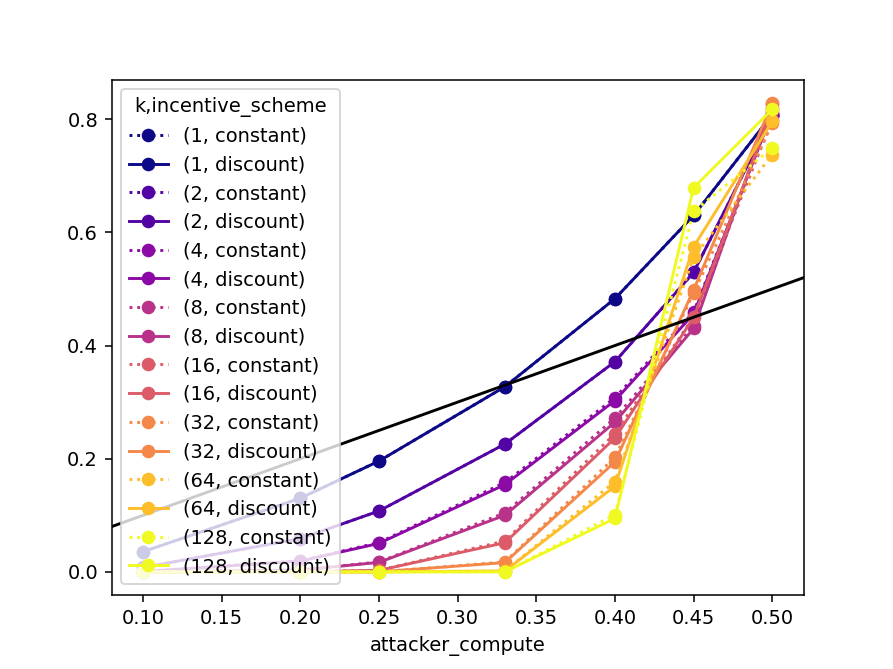

In [4]:
# compare same strategy for incentive schemes
dd = d[d.strategy == 'private-override-catchup']
dd = dd.pivot(index=['attacker_compute'], columns=['k', 'incentive_scheme'], values='attacker_relative_reward')
dd = dd[sorted(dd.columns)]
line_style = [ 'o-' if proto == 'discount' else 'o:' for (k, proto) in  dd.columns]
k = np.unique([ k for (k, proto) in dd.columns])
cmap = plt.cm.get_cmap('plasma', len(k))
colormap = { k: cmap(i) for (i, k) in enumerate(k) }
line_colors = [ colormap[k] for (k, proto) in dd.columns ]
line_colors
p = dd.plot(style=line_style, color=line_colors)
p.axline([.1, .1], [.5, .5], color='black')

<IPython.core.display.Javascript object>


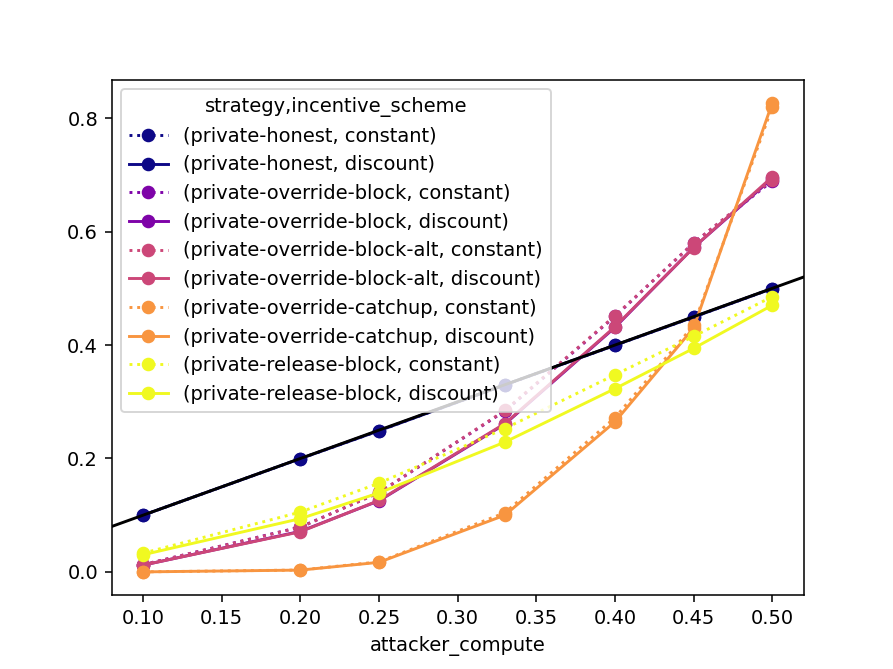

In [12]:
# compare same strategies for incentive scheme
dd = d
dd = dd[dd.k == 8]
dd = dd.pivot(index=['attacker_compute'], columns=['strategy', 'incentive_scheme'], values='attacker_relative_reward')
dd = dd[sorted(dd.columns)]
line_style = [ 'o-' if proto == 'discount' else 'o:' for (k, proto) in  dd.columns]
k = np.unique([ k for (k, proto) in dd.columns])
cmap = plt.cm.get_cmap('plasma', len(k))
colormap = { k: cmap(i) for (i, k) in enumerate(k) }
line_colors = [ colormap[k] for (k, proto) in dd.columns ]
line_colors
p = dd.plot(style=line_style, color=line_colors)
p.axline([.1, .1], [.5, .5], color='black')

<IPython.core.display.Javascript object>


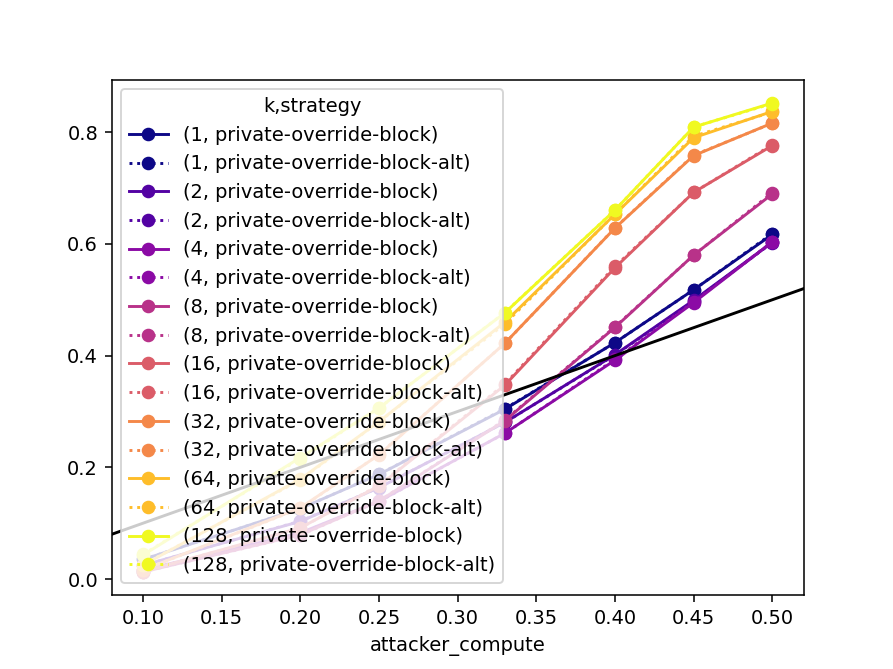

In [6]:
# does numerical implementation line up with non-numerical implementation of policiy?
dd = d
dd = dd[dd['protocol']=='george']
dd = dd[(dd['strategy']=='private-override-block') | (dd['strategy']=='private-override-block-alt')]
dd = dd[dd['incentive_scheme']=='constant']
dd = dd.pivot(index=['attacker_compute'], columns=['k', 'strategy'], values='attacker_relative_reward')
dd = dd[sorted(dd.columns)]
line_style = [ 'o-' if proto == 'private-override-block' else 'o:' for (k, proto) in  dd.columns]
k = np.unique([ k for (k, proto) in dd.columns])
cmap = plt.cm.get_cmap('plasma', len(k))
colormap = { k: cmap(i) for (i, k) in enumerate(k) }
line_colors = [ colormap[k] for (k, proto) in dd.columns ]
line_colors
p = dd.plot(style=line_style, color=line_colors)
p.axline([.1, .1], [.5, .5], color='black')
# It does line up!